# Importing required libraries

In [135]:
!pip install keras_tuner

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import root_mean_squared_error, mean_squared_error
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta
from keras_tuner.tuners import RandomSearch,Hyperband
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import r2_score

# Data preprocessing and exploration

In [137]:
# importing the dataset
df=pd.read_csv('AAPL.csv')

In [138]:
# information of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2011 entries, 0 to 2010
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2011 non-null   object 
 1   Open       2011 non-null   float64
 2   High       2011 non-null   float64
 3   Low        2011 non-null   float64
 4   Close      2011 non-null   float64
 5   Adj Close  2011 non-null   float64
 6   Volume     2011 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 110.1+ KB


In [139]:
df['Date'] = pd.to_datetime(df['Date'])

In [140]:
# preview of the data
df.head()

Date       Open       High        Low      Close  Adj Close    Volume
0 2012-01-03  58.485714  58.928570  58.428570  58.747143  50.765709  75555200
1 2012-01-04  58.571430  59.240002  58.468571  59.062859  51.038536  65005500
2 2012-01-05  59.278572  59.792858  58.952858  59.718571  51.605175  67817400
3 2012-01-06  59.967144  60.392857  59.888573  60.342857  52.144630  79573200
4 2012-01-09  60.785713  61.107143  60.192856  60.247143  52.061932  98506100

In [141]:
df.tail()

Date        Open        High         Low       Close   Adj Close  \
2006 2019-12-23  280.529999  284.250000  280.369995  284.000000  282.054138   
2007 2019-12-24  284.690002  284.890015  282.920013  284.269989  282.322266   
2008 2019-12-26  284.820007  289.980011  284.700012  289.910004  287.923645   
2009 2019-12-27  291.119995  293.970001  288.119995  289.799988  287.814392   
2010 2019-12-30  289.459991  292.690002  285.220001  291.519989  289.522614   

        Volume  
2006  24643000  
2007  12119700  
2008  23280300  
2009  36566500  
2010  36028600

In [142]:
# checking for null values
df.isnull().sum().sum()

np.int64(0)

- There are no null values

In [143]:
df.select_dtypes(include=['number']).describe()

Open         High          Low        Close    Adj Close  \
count  2011.000000  2011.000000  2011.000000  2011.000000  2011.000000   
mean    126.707469   127.827594   125.580258   126.741235   119.505548   
std      50.483753    50.926301    50.124940    50.578369    52.438444   
min      55.424286    57.085712    55.014286    55.790001    48.921928   
25%      85.882858    86.717858    85.056427    86.202145    75.056679   
50%     113.050003   114.190002   111.870003   113.050003   105.222908   
75%     165.190002   167.409996   163.424995   165.245002   160.047111   
max     291.119995   293.970001   288.119995   291.519989   289.522614   

             Volume  
count  2.011000e+03  
mean   5.949670e+07  
std    4.683856e+07  
min    1.136200e+07  
25%    2.758565e+07  
50%    4.346900e+07  
75%    7.471030e+07  
max    3.765300e+08

**Data Describtion :-**

    Date : Date of trading

    Open : Price at which security first trades

    High : Highest Price of the trading day

    Low : Lowest Price of the trading day

    Close : Last Price the stock traded during the trading day

    Adj Close : Price that is adjusts Coroporate Actions on Closing Price

    Volume : Number of Shares that changed hands during the trading day

In [144]:
df['month']=df['Date'].dt.month_name()
df['year']=df['Date'].dt.year
df['dayofweek']=df['Date'].dt.day_name()
df['quarter']=df['Date'].dt.quarter
df.head()


Date       Open       High        Low      Close  Adj Close    Volume  \
0 2012-01-03  58.485714  58.928570  58.428570  58.747143  50.765709  75555200   
1 2012-01-04  58.571430  59.240002  58.468571  59.062859  51.038536  65005500   
2 2012-01-05  59.278572  59.792858  58.952858  59.718571  51.605175  67817400   
3 2012-01-06  59.967144  60.392857  59.888573  60.342857  52.144630  79573200   
4 2012-01-09  60.785713  61.107143  60.192856  60.247143  52.061932  98506100   

     month  year  dayofweek  quarter  
0  January  2012    Tuesday        1  
1  January  2012  Wednesday        1  
2  January  2012   Thursday        1  
3  January  2012     Friday        1  
4  January  2012     Monday        1

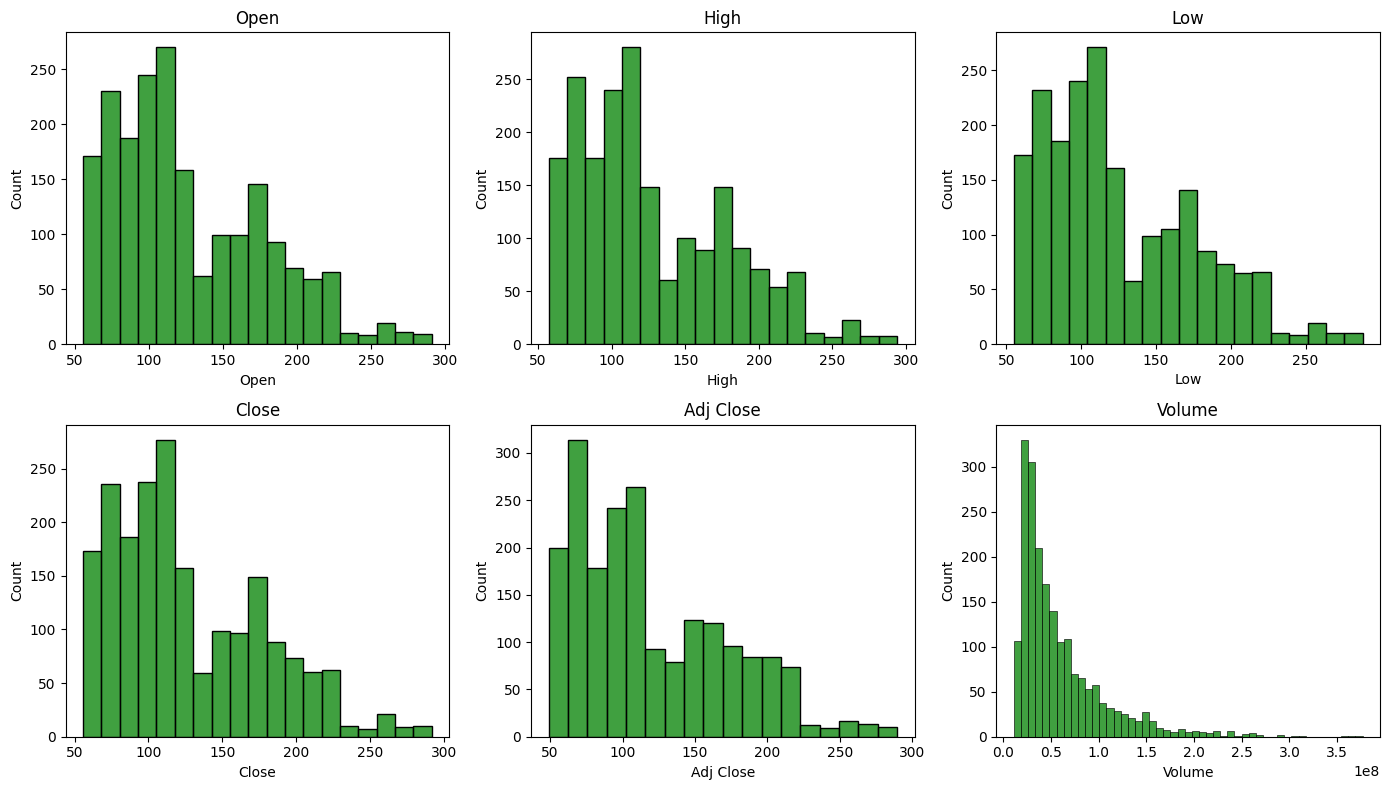

In [145]:
plt.figure(figsize=(14,8))
for i,col in enumerate(df.columns[1:-4], 1):
    plt.subplot(2,3,i)
    sns.histplot(df[col], color='green')
    plt.title(f'{col}')
plt.tight_layout()
plt.show()

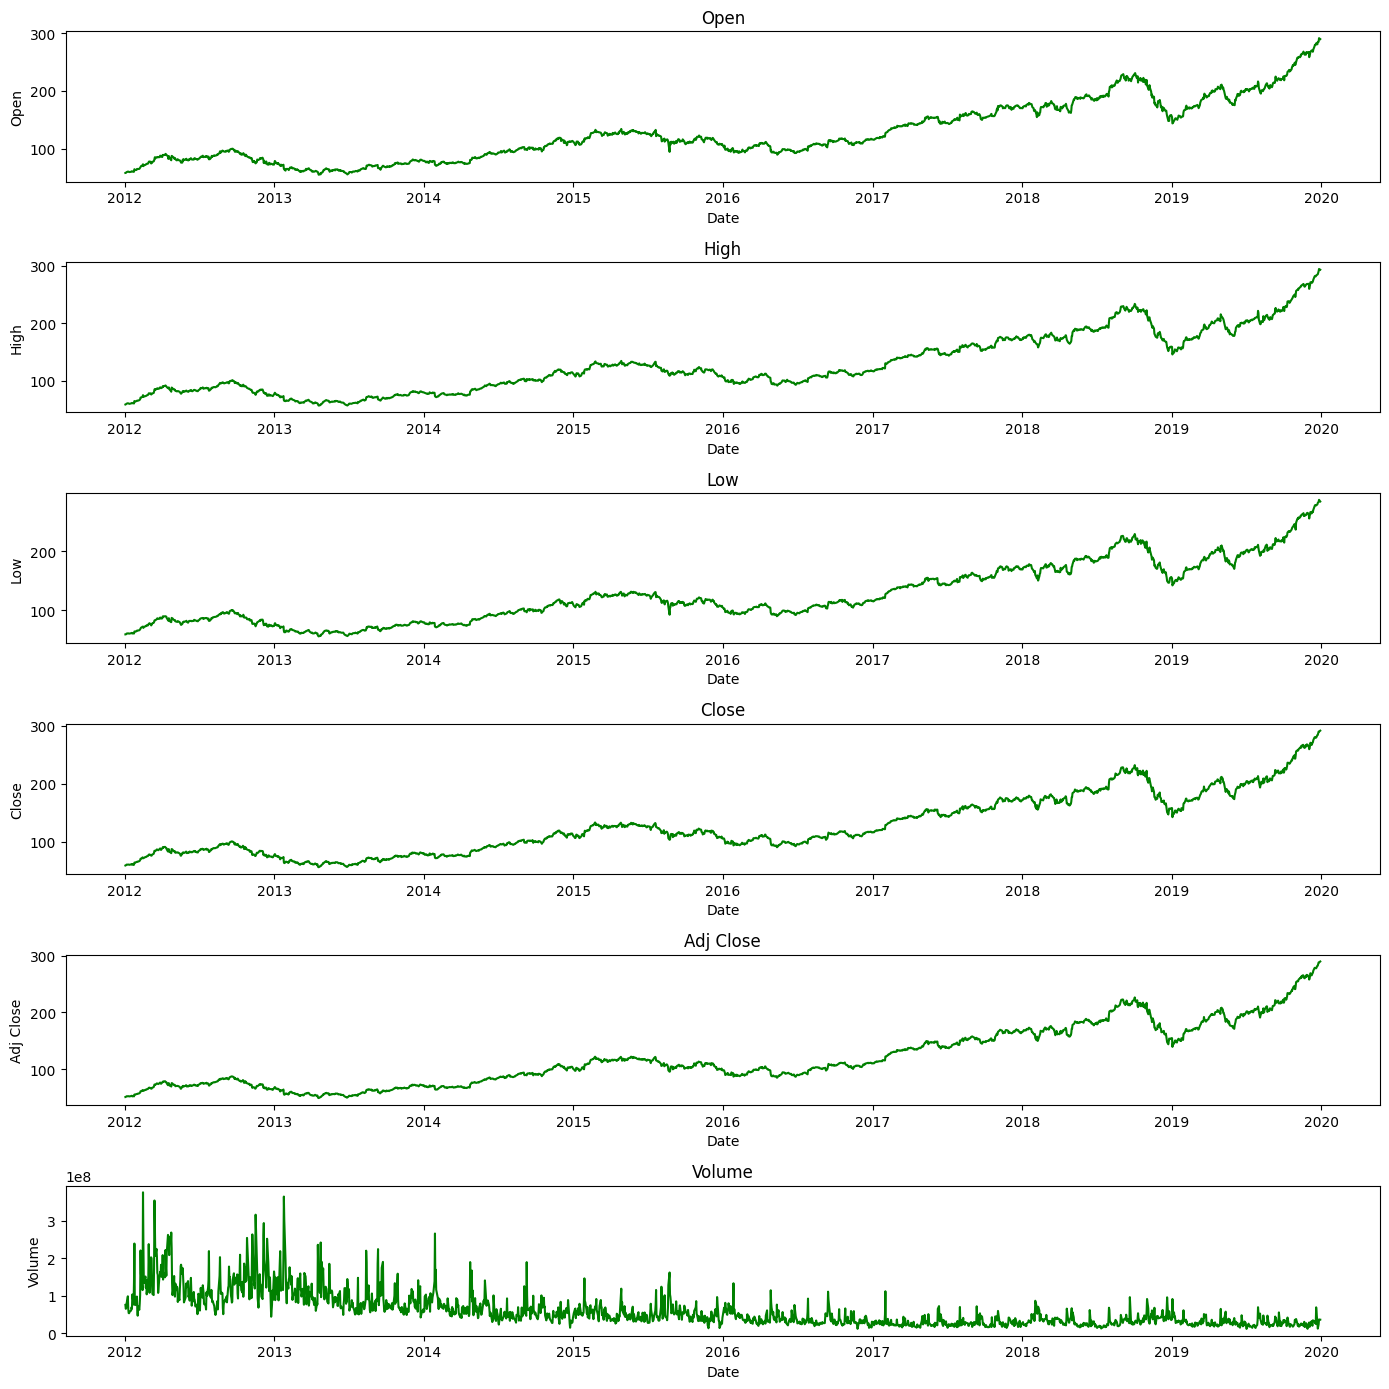

In [146]:
import matplotlib.dates as mdates
plt.figure(figsize=(14, 14))
for i, col in enumerate(df.columns[1:-4], 1):
    plt.subplot(6, 1, i)
    sns.lineplot(x=df['Date'], y=df[col], color='green')  
    plt.title(f'{col}')
    
    # Format the x-axis to show only years
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())  
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  

plt.tight_layout()
plt.show()

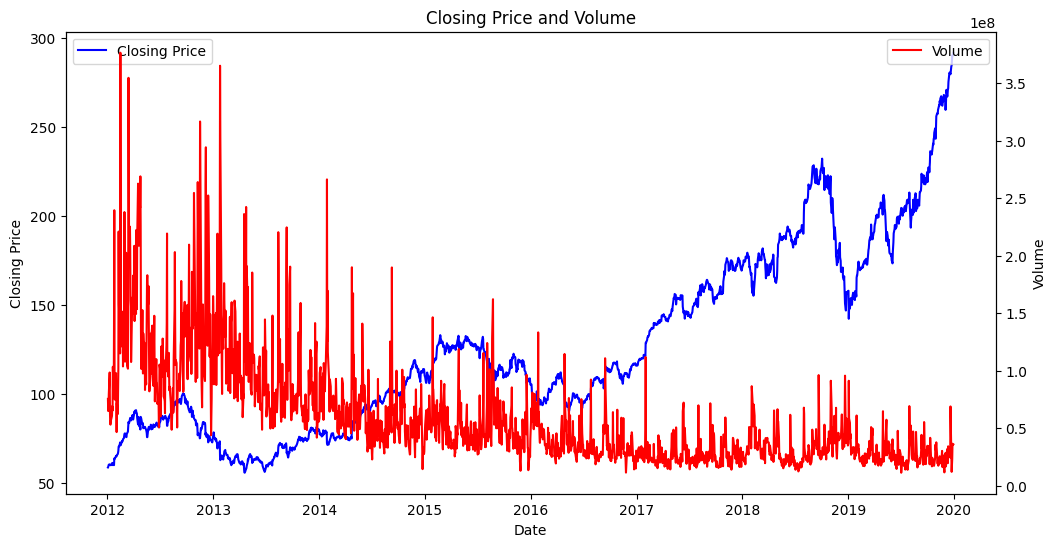

In [147]:
plt.figure(figsize=(12, 6))


ax1 = plt.gca()
sns.lineplot(x='Date', y='Close', data=df, ax=ax1, color='blue', label='Closing Price')
ax1.set_ylabel('Closing Price')
ax1.set_xlabel('Date')


# Create the second axis for 'Volume'
ax2 = ax1.twinx()  
sns.lineplot(x='Date', y='Volume', data=df, ax=ax2, color='red', label='Volume')
ax2.set_ylabel('Volume')

plt.title('Closing Price and Volume')
plt.show()

**Plot inference**:As the closing price increases, the volume decreases, indicating that fewer shares are being traded

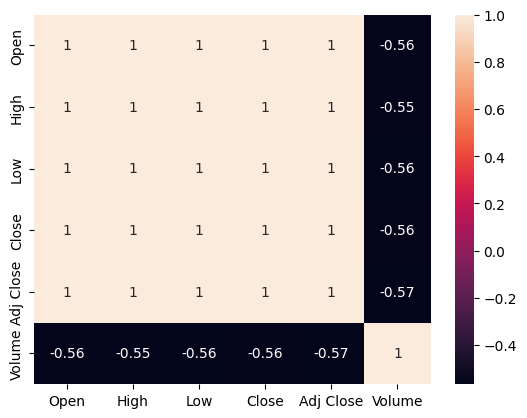

In [148]:
corr=df.iloc[:,1:-4].corr()

sns.heatmap(corr,annot=True)
plt.show()

- We can eliminate features like Open, Low, High, and Adj Close as they are highly multicollinear with Close. 
- We consider Close as our target variable since it represents the actual market price at which the stock was last traded during a given period, making it a key indicator for price trend analysis.

## Filtering the data to closing price

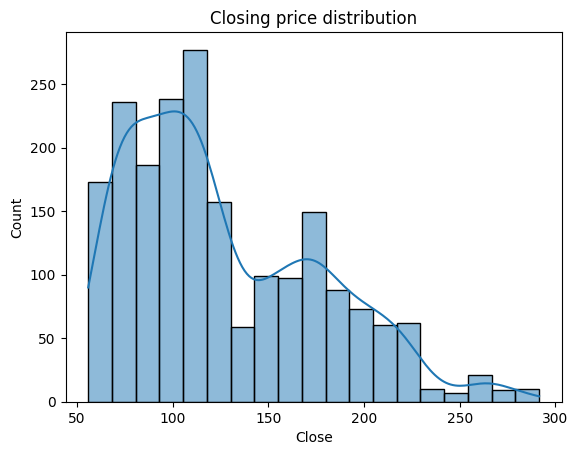

In [149]:
sns.histplot(df['Close'],kde=True)
plt.title("Closing price distribution")
plt.show()

**Plot Inference:** Right skewed

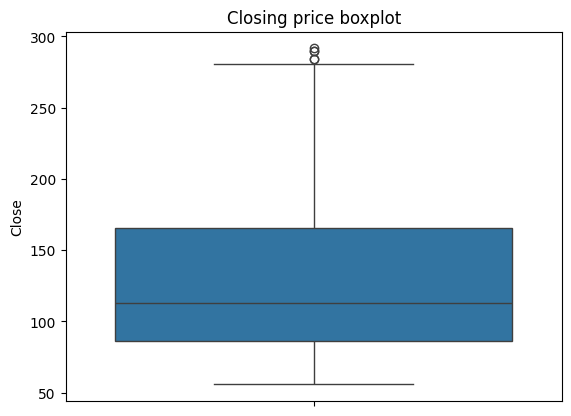

In [150]:
sns.boxplot(df['Close'])
plt.title("Closing price boxplot")
plt.show()

In [151]:
print('Skewness of Distribution is ',df['Close'].skew())
print('Kurtosis of Distribution is ',df['Close'].kurtosis())

Skewness of Distribution is  0.7738383526895003
Kurtosis of Distribution is  -0.15503801824484675


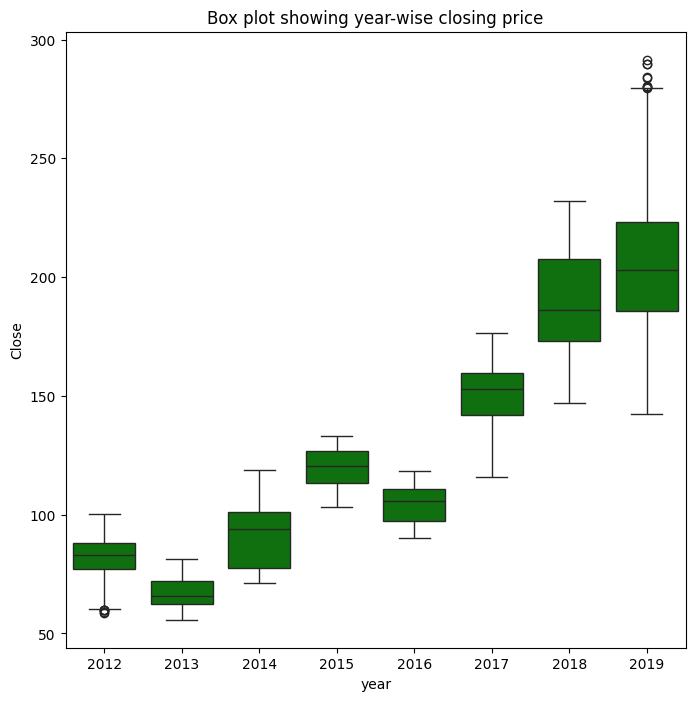

In [152]:

plt.figure(figsize=(8,8))
sns.boxplot(df,x='year', y='Close',color='green' )
plt.title('Box plot showing year-wise closing price')
plt.show()

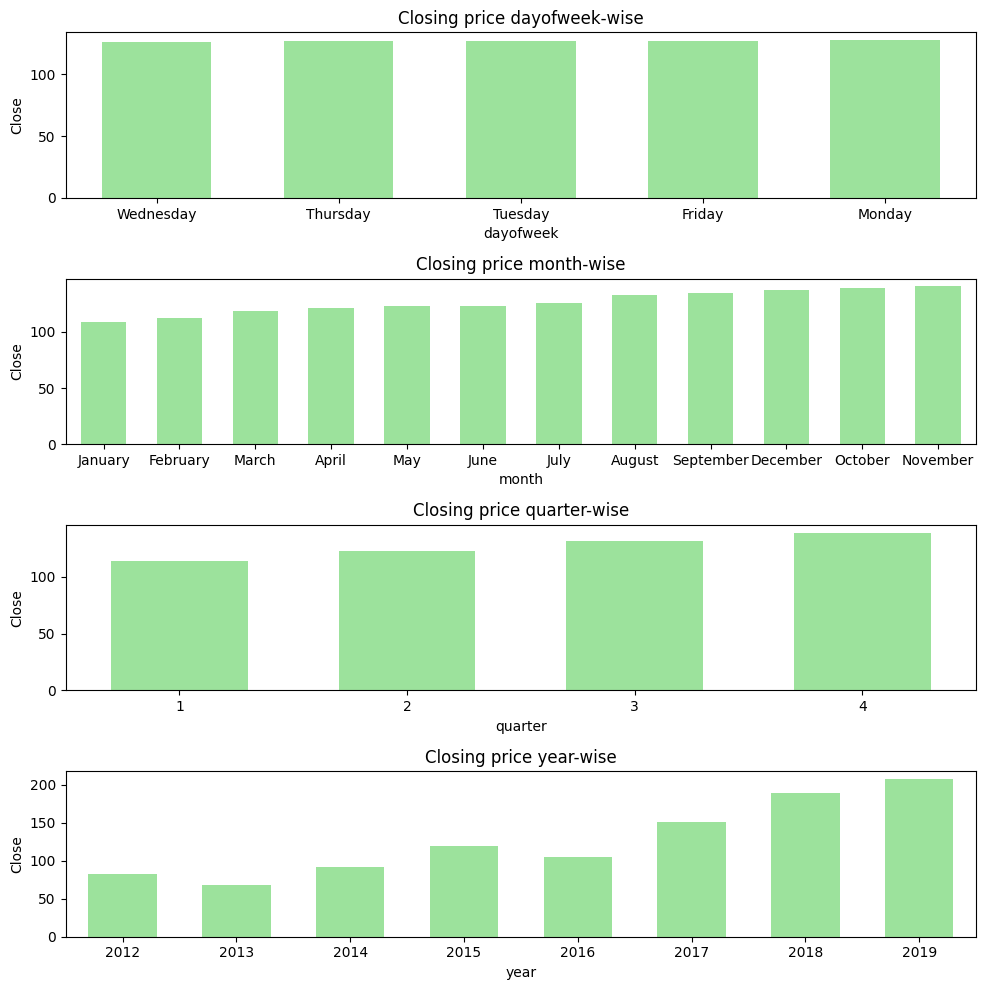

In [154]:

columns=['dayofweek','month','quarter','year',]

plt.figure(figsize=(10,10))
for i,j in enumerate(columns,1):
    temp=df.groupby(j).agg({'Close':'mean'}).reset_index()
    temp = temp.sort_values(by="Close")
    plt.subplot(4,1,i)
    sns.barplot(temp,x=j,y='Close', color='lightgreen', width=0.6)
    plt.title(f"Closing price {j}-wise")
plt.tight_layout()
plt.show()



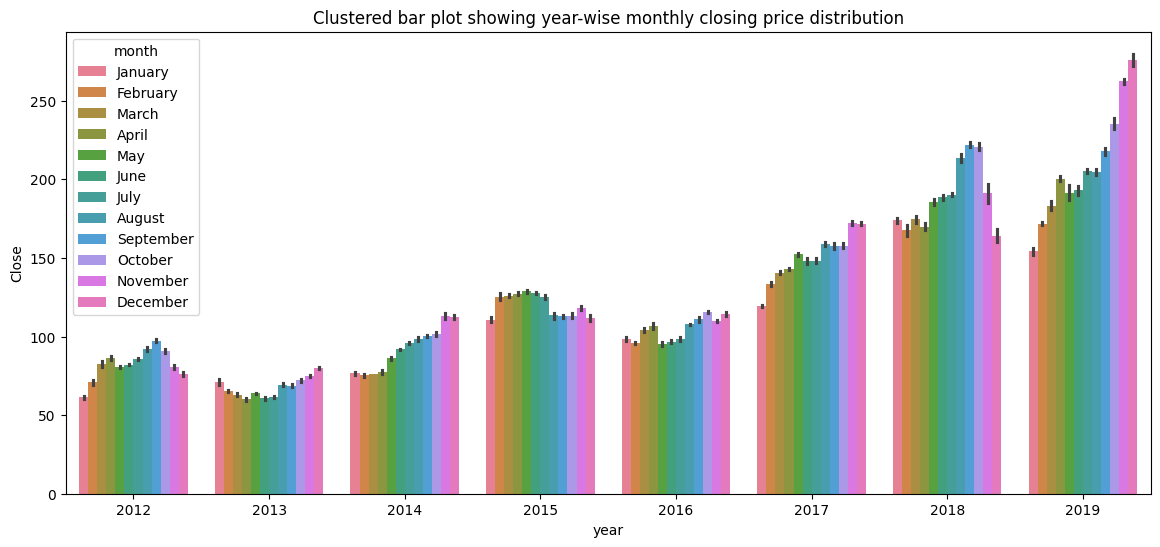

In [153]:
plt.figure(figsize=(14,6))
sns.barplot(df,x='year', y='Close',hue='month' )
plt.title('Clustered bar plot showing year-wise monthly closing price distribution')
plt.show()

- Outliers in 2012 and 2019 suggest volatile periods, while declines in 2013 and 2016 point to downturns or weaker investor sentiment.
- The increasing trend in closing prices indicates a general growth in stock value over time.
- Monday's consistently high closing prices and the end-of-month peaks reflect particular patterns in investor behavior, with higher activity at the start and end of the week and month.
- The last quarter sees a notable rise in prices, likely driven by end-of-year market adjustments.
- Overall, despite some volatility and occasional declines, the data shows an upward trend in stock prices, particularly towards the end of the analyzed period.

In [155]:
# Filtering out the closing price 
df1=df[['Close']]

df1['log_close']=np.log(df1['Close'])

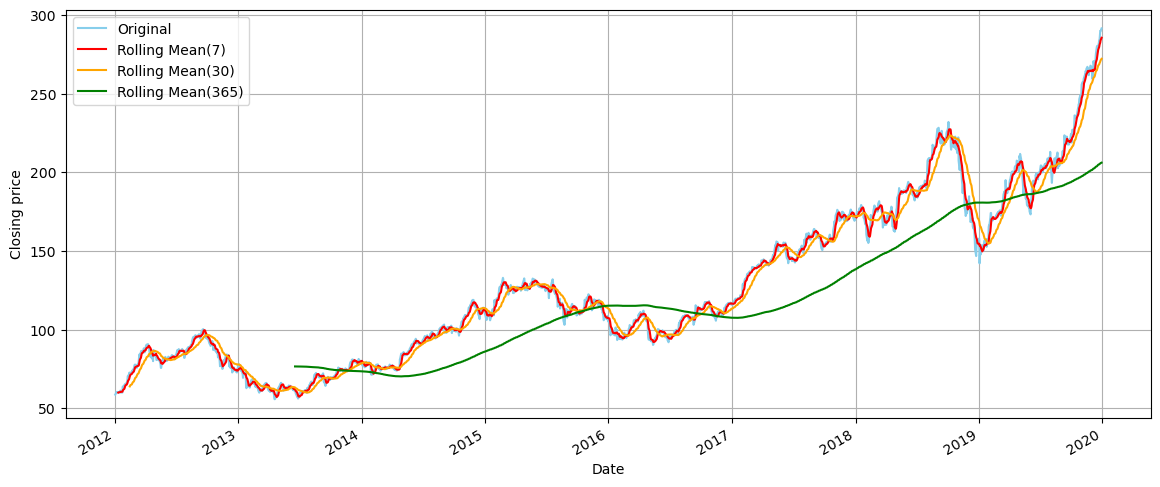

In [215]:
plt.figure(figsize=(14,6))
sns.lineplot(df1['Close'], label='Original', color='skyblue')
df1['Close'][1:].rolling(7).mean().plot(label='Rolling Mean(7)', color='red')
df1['Close'][1:].rolling(30).mean().plot(label='Rolling Mean(30)', color='orange')
df1['Close'][1:].rolling(365).mean().plot(label='Rolling Mean(365)', color='green')
plt.ylabel('Closing price')
plt.legend()
plt.grid(True)
plt.show()

- Original: The blue line represents the original closing price data. It shows significant fluctuations, indicating a high level of volatility.

- 
Rolling Mean(7): The orange line represents a 7-day rolling mean. This line is smoother than the original data, suggesting a short-term trend. However, it still shows fluctuations, implying that the stock price changes frequently in the short term

- Rolling Mean(30): The blue line represents a 30-day rolling mean. This line is smoother than the 7-day rolling mean but shows more fluctuations than the 365-day rolling mean, indicating a trend that exists between short-term and long-term.

- Rolling Mean(365): The pink line represents a 365-day rolling mean. This line is smoother than the previous two, indicating a long-term trend. The smoothness suggests a yearly seasonality in the closing price.  e- .

Therefore, the graph suggests that the closing price of the stock exhibits seasonality on a yearly basis. The long-term trend (represented by the 365-day rolling mean) is smoother than the short-term trends (represented by the 7 and 30-day rolling means), indicating that the stock price is more stable over a longer period.


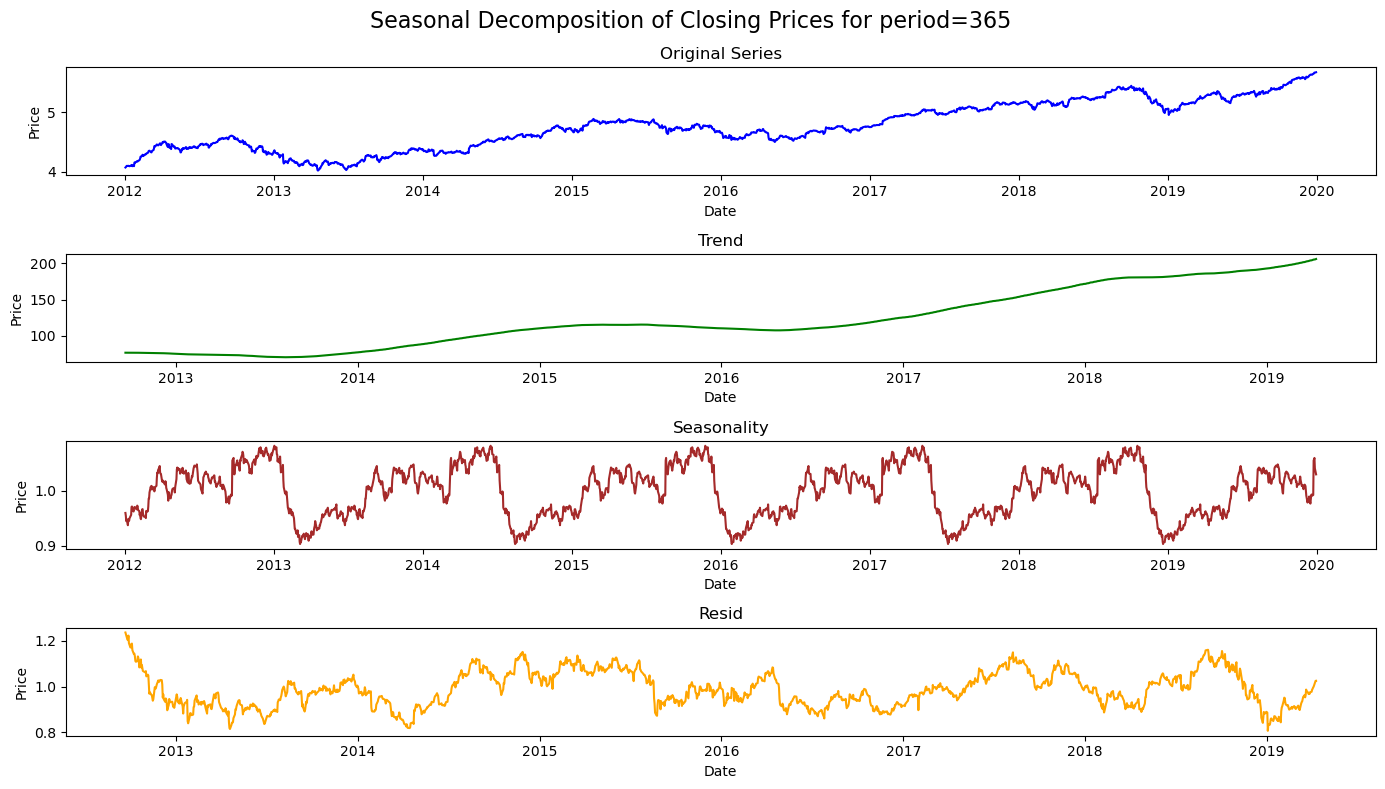

In [219]:
result = seasonal_decompose(df1['Close'], model='multiplicative', period=365)

plt.figure(figsize=(14,8))
plt.suptitle('Seasonal Decomposition of Closing Prices for period=365', fontsize=16)
plt.subplot(4,1,1)
sns.lineplot(x=df1.index, y=df1['log_close'], color='blue')
plt.title('Original Series')
plt.ylabel('Price')

plt.subplot(4,1,2)
sns.lineplot(x=df1.index, y=result.trend, color='green')
plt.title('Trend')
plt.ylabel('Price')

plt.subplot(4,1,3)
sns.lineplot(x=df1.index, y=result.seasonal, color='brown')
plt.title('Seasonality')
plt.ylabel('Price')

plt.subplot(4,1,4)
sns.lineplot(x=df1.index, y=result.resid, color='orange')
plt.title('Resid')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

**stationarity:**
The main conditions for stationarity are:

* Constant Mean: The mean (average) of the series should remain stable over time.
* Constant Variance: The spread (variance) of the series should not change   over time.
* Constant Covariance: The relationship between values at different time lags should remain consistent.             

Hence, the series is non-stationary. Techniques like differencing or log transformation are often applied to make the data stationary before modeling.

In [218]:
# using augmented dickey fuller test for stationarity check
result = adfuller(df1['log_close'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -0.27401408154659834
p-value: 0.929104933772776


In [287]:
# first order differencing as the data is non-stationary
df1['diff'] =df1['log_close']-df1['log_close'].shift(1)
df1.dropna(inplace=True)

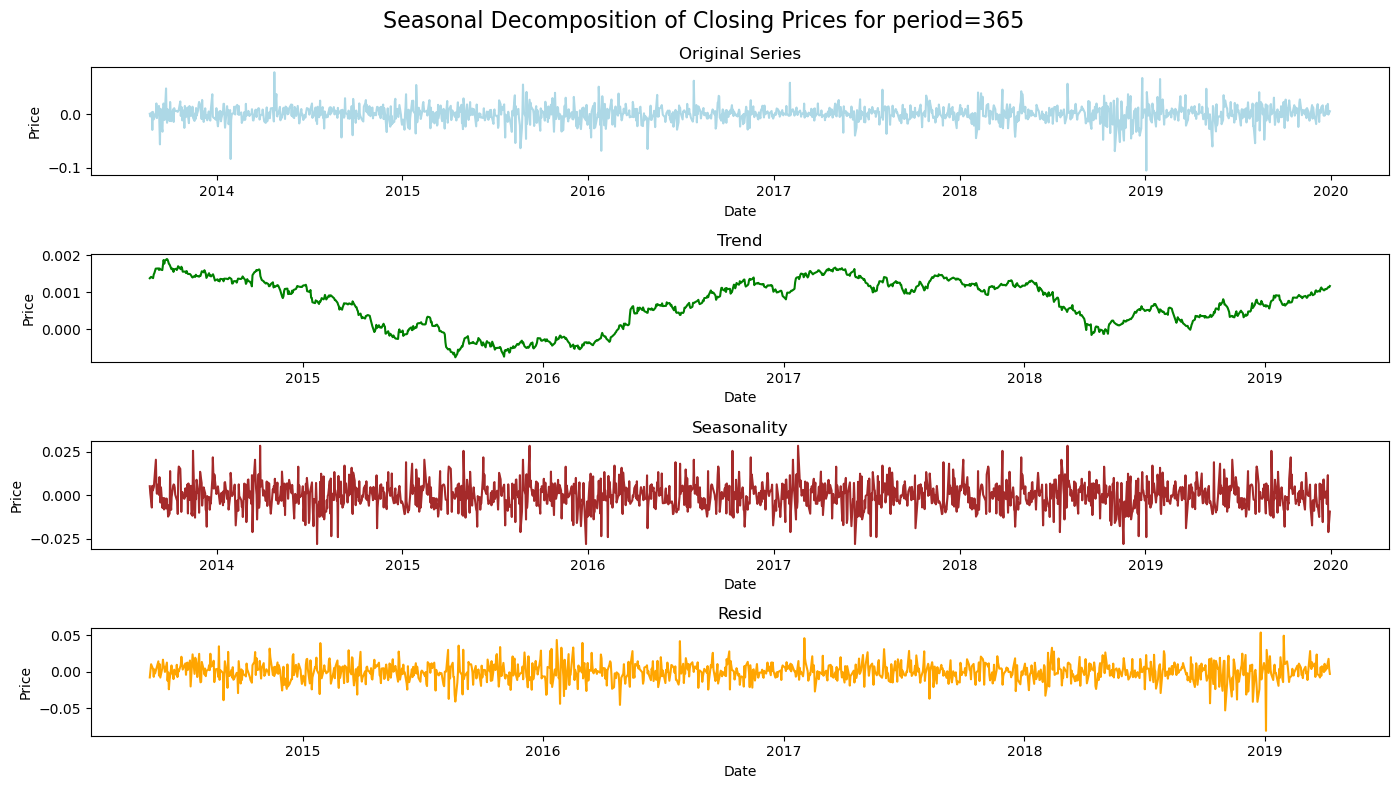

In [270]:
result = seasonal_decompose(df1['diff'], model='add', period=365)

plt.figure(figsize=(14,8))
plt.suptitle('Seasonal Decomposition of Closing Prices for period=365', fontsize=16)
plt.subplot(4,1,1)
sns.lineplot(x=df1.index, y=df1['diff'], color='lightblue')
plt.title('Original Series')
plt.ylabel('Price')

plt.subplot(4,1,2)
sns.lineplot(x=df1.index, y=result.trend, color='green')
plt.title('Trend')
plt.ylabel('Price')

plt.subplot(4,1,3)
sns.lineplot(x=df1.index, y=result.seasonal, color='brown')
plt.title('Seasonality')
plt.ylabel('Price')

plt.subplot(4,1,4)
sns.lineplot(x=df1.index, y=result.resid, color='orange')
plt.title('Resid')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

In [288]:
result = adfuller(df1['diff'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {np.round(result[1],4)}')

ADF Statistic: -15.755566347955524
p-value: 0.0


#### Now the series is stationary

In [289]:
df1.head()

Close  log_close      diff
1  59.062859   4.078602  0.005360
2  59.718571   4.089643  0.011041
3  60.342857   4.100043  0.010400
4  60.247143   4.098455 -0.001587
5  60.462856   4.102029  0.003574

#### Plotting autocorrelation (acf) and partial autocorrelation plot (pacf) to choose p, q values

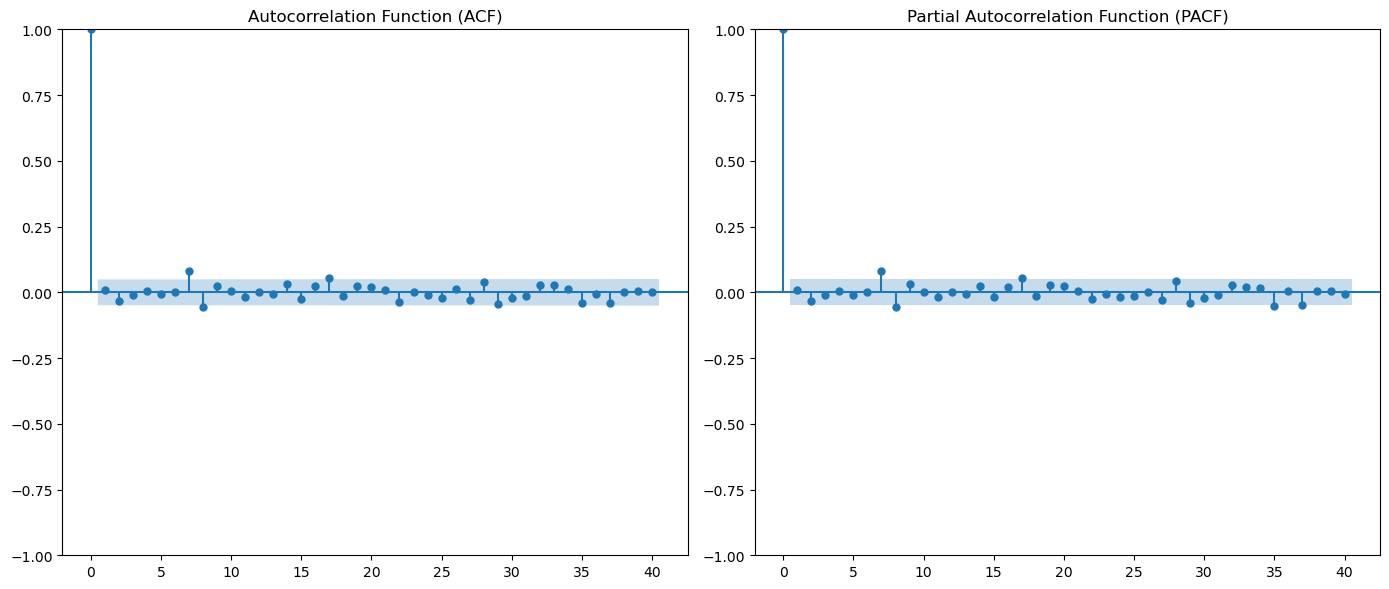

In [273]:
plt.figure(figsize=(14, 6))
# Autocorrelation Plot
plt.subplot(1, 2, 1)
plot_acf(df1['diff'], lags=40, ax=plt.gca()) 
plt.title('Autocorrelation Function (ACF)')

# Partial Autocorrelation Plot
plt.subplot(1, 2, 2)
plot_pacf(df1['diff'], lags=40, ax=plt.gca(), method='ywm') 
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

In [283]:
# autoregression order from pacf plot
q= 7
# moving-average order from acf plot
p= 7

In [290]:
# train and test split
train=df1.iloc[:-252]
# last year considering as test series without including weekends
test=df1.iloc[-252:]    

train.shape, test.shape

((1758, 3), (252, 3))

# Model Building

## Arima Model
- Best For: Non-seasonal data with trends.
- Why: ARIMA models are widely used because they capture trends, lags, and relationships within the data through autoregression and moving averages. They’re very effective for stationary data or data that can be made stationary through differencing.
- Limitations: ARIMA does not handle seasonality well without extensions like SARIMA (Seasonal ARIMA), which adds seasonal components.

#### finding the best value for (P,Q,D)

In [563]:
p_values=range(2,8)
q_values=range(2,8)
d_values=range(0,2)
for p in p_values:
    for q in q_values:
        for d in d_values:
            arima_model=ARIMA(train['diff'],order=(p,d,q))
            arima_model=arima_model.fit()
            forecast_steps = 252
            forecast = arima_model.forecast(steps=forecast_steps)
            forecast_org = forecast.cumsum() + df1['Close'].iloc[-252 - 1]
            print(f"{(p,d,q)} RMSE:",root_mean_squared_error(forecast_org,test['Close']))

(2, 0, 2) RMSE: 54.37032965266886
(2, 1, 2) RMSE: 53.93793513013034
(2, 0, 3) RMSE: 54.062423816464936
(2, 1, 3) RMSE: 53.96435422881711
(2, 0, 4) RMSE: 54.341871327477655
(2, 1, 4) RMSE: 53.93820481912413
(2, 0, 5) RMSE: 54.271777986761705
(2, 1, 5) RMSE: 54.652524935155725
(2, 0, 6) RMSE: 54.23936655999803
(2, 1, 6) RMSE: 54.3785707529134
(2, 0, 7) RMSE: 54.71049162740322
(2, 1, 7) RMSE: 54.87515374709896
(3, 0, 2) RMSE: 54.230668593238555
(3, 1, 2) RMSE: 53.91954268402074
(3, 0, 3) RMSE: 54.283932186507684
(3, 1, 3) RMSE: 53.900474284030594
(3, 0, 4) RMSE: 54.85084285430123
(3, 1, 4) RMSE: 53.83551522661193
(3, 0, 5) RMSE: 59.582443513818006
(3, 1, 5) RMSE: 55.69614195557879
(3, 0, 6) RMSE: 58.952956132095075
(3, 1, 6) RMSE: 53.796225341588446
(3, 0, 7) RMSE: 54.47620853410215
(3, 1, 7) RMSE: 131.4590296236542
(4, 0, 2) RMSE: 54.0318249515859
(4, 1, 2) RMSE: 128.85219481318282
(4, 0, 3) RMSE: 68.37564592492018
(4, 1, 3) RMSE: 116.30012427378462
(4, 0, 4) RMSE: 54.23015660472232
(4, 

In [293]:
p=7
q=6
d=0 # as we already differenced the data
arima_model=ARIMA(train['diff'],order=(p,d,q))
arima_model=arima_model.fit()
print(arima_model.summary())

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   diff   No. Observations:                 1758
Model:                 ARIMA(7, 0, 6)   Log Likelihood                4772.203
Date:                Sat, 30 Nov 2024   AIC                          -9514.406
Time:                        15:11:09   BIC                          -9432.327
Sample:                             0   HQIC                         -9484.071
                               - 1758                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.323      0.186      -0.000       0.001
ar.L1         -0.9638      0.563     -1.713      0.087      -2.067       0.139
ar.L2         -1.0658      0.597     -1.786      0.0

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [565]:
forecast_steps = 252
pd.date_range(start=train.index[-1], periods=forecast_steps + 1, freq='B')[1:]

DatetimeIndex(['2018-12-31', '2019-01-01', '2019-01-02', '2019-01-03',
               '2019-01-04', '2019-01-07', '2019-01-08', '2019-01-09',
               '2019-01-10', '2019-01-11',
               ...
               '2019-12-04', '2019-12-05', '2019-12-06', '2019-12-09',
               '2019-12-10', '2019-12-11', '2019-12-12', '2019-12-13',
               '2019-12-16', '2019-12-17'],
              dtype='datetime64[ns]', length=252, freq='B')

In [294]:
# forecasting for next 252 days
forecast_steps = 252
forecast = arima_model.forecast(steps=forecast_steps)

# reverse differencing
forecast_org = forecast.cumsum() + df1['Close'].iloc[-252 - 1]

forecast_index = pd.date_range(start=train.index[-1], periods=forecast_steps + 1, freq='B')[1:]

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [298]:
# train predictions
train_predictions=arima_model.predict(start=0, end=1757)
# converting to original form
train_predictions_org=train_predictions.cumsum()+df1['Close'].iloc[0]
train_predictions_org

1       59.063401
2       59.063989
3       59.064331
4       59.064383
5       59.064629
          ...    
1754    60.014865
1755    60.014513
1756    60.009463
1757    60.018458
1758    60.016129
Name: predicted_mean, Length: 1758, dtype: float64

In [296]:
train['Close']

1        59.062859
2        59.718571
3        60.342857
4        60.247143
5        60.462856
           ...    
1754    150.729996
1755    146.830002
1756    157.169998
1757    156.149994
1758    156.229996
Name: Close, Length: 1758, dtype: float64

In [299]:
#RMSE 
arima_train_rmse=root_mean_squared_error(train['Close'],train_predictions_org )
arima_test_rmse=root_mean_squared_error(forecast_org,test['Close'] )
print("RMSE for train of ARIMA Model:",arima_train_rmse)
print("RMSE for test of ARIMA Model:",arima_test_rmse)

RMSE for train of ARIMA Model: 68.96372393027494
RMSE for test of ARIMA Model: 61.73059920481023


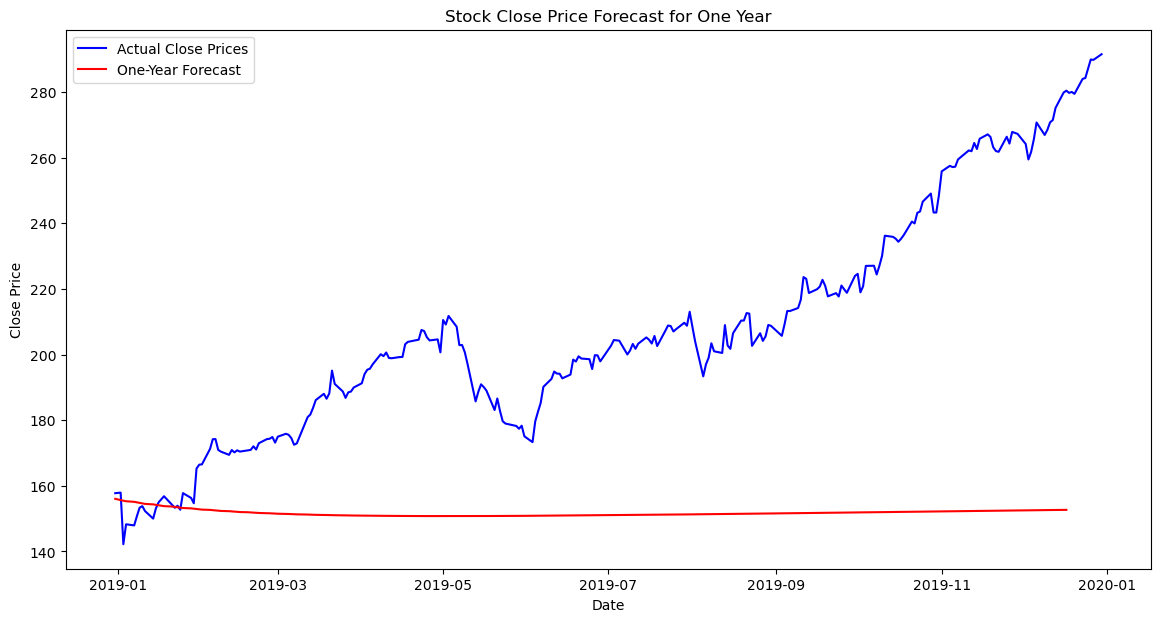

In [264]:
plt.figure(figsize=(14, 7))
plt.plot(test['Close'], label='Actual Close Prices', color='blue')
plt.plot(forecast_index, forecast_org, label='One-Year Forecast', color='red')
plt.title('Stock Close Price Forecast for One Year')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

#### ARIMA model is doing very bad

## SARIMA
- Best For: Seasonal data with trends.
- Why: SARIMA builds on ARIMA by adding seasonal elements, making it a robust choice for data with both trend and seasonal patterns (e.g., quarterly or monthly sales data).
- Limitations: Model complexity increases with added parameters for seasonality. It also requires data to be well-behaved (not too noisy) and somewhat consistent in seasonal patterns

In [185]:
p=7
q=6
d=0 # as we already differenced the data
sarimax_model=SARIMAX(train['diff'],order=(p,d,q),seasonal_order=(p,d,q,12),disp=True)
sarimax_model=sarimax_model.fit()
sarimax_model.summary()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               diff   No. Observations:                 1758
Model:             SARIMAX(7, 0, 6)x(7, 0, 6, 12)   Log Likelihood               -3611.388
Date:                            Wed, 20 Nov 2024   AIC                           7276.776
Time:                                    17:18:30   BIC                           7424.518
Sample:                                         0   HQIC                          7331.378
                                           - 1758                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7704      0.220     -3.509      0.000      -1.201      -0.340
ar.L2         -0.9348      0.343     -2.727      0.006      -1.606      -0.263
ar.L3         -0.0642      0.463     -0.139      0.890      -0.971       0.843
ar.L4          0.0890      0.429      0.208      0.836      -0.752       0.930
ar.L5          0.3751      0.282      1.331      0.183      -0.177       0.927
ar.L6         -0.0410      0.161     -0.255      0.799      -0.357       0.275
ar.L7          0.1151      0.024      4.877      0.000       0.069       0.161
ma.L1          0.8111      0.222      3.649      0.000       0.375       1.247
ma.L2          0.9312      0.350      2.661      0.008       0.245       1.617
ma.L3          0.0407      0.474      0.086      0.931      -0.887       0.969
ma.L4         -0.1163      0.435     -0.268      0.789      -0.968       0.736
ma.L5         -0.3656      0.280     -1.307      0.191      -0.914       0.183
ma.L6          0.0756      0.164      0.460      0.645      -0.246       0.397
ar.S.L12      -0.6627      1.282     -0.517      0.605      -3.175       1.849
ar.S.L24      -0.3664      0.344     -1.064      0.287      -1.041       0.309
ar.S.L36      -0.0345      0.283     -0.122      0.903      -0.589       0.520
ar.S.L48       0.6267      0.177      3.541      0.000       0.280       0.974
ar.S.L60       0.7960      0.847      0.940      0.347      -0.863       2.455
ar.S.L72       0.4904      0.644      0.761      0.447      -0.773       1.753
ar.S.L84      -0.0028      0.051     -0.056      0.955      -0.102       0.097
ma.S.L12       0.6677      1.277      0.523      0.601      -1.835       3.171
ma.S.L24       0.3233      0.350      0.924      0.356      -0.363       1.009
ma.S.L36       0.0048      0.237      0.020      0.984      -0.459       0.469
ma.S.L48      -0.6165      0.172     -3.579      0.000      -0.954      -0.279
ma.S.L60      -0.8076      0.816     -0.990      0.322      -2.406       0.791
ma.S.L72      -0.4808      0.672     -0.715      0.474      -1.798       0.837
sigma2         3.5495      0.073     48.395      0.000       3.406       3.693
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2461.13
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               3.31   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [186]:
forecast=sarimax_model.forecast(steps=252)
forecast_org= forecast.cumsum() + df1['Close'].iloc[-252-1]
forecast_index= pd.date_range(start=train.index[-1],periods=forecast_steps+1,freq='B')[1:]

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [188]:
# train predictions
train_predictions=sarimax_model.predict(start=0, end=1757)
train_predictions_org=train_predictions.cumsum()+df1['Close'].iloc[0]

# RMSE
sarima_train_rmse=root_mean_squared_error(train['Close'],train_predictions_org )
sarima_test_rmse=root_mean_squared_error(forecast_org,test['Close'] )
print("RMSE for train of ARIMA Model:",sarima_train_rmse)
print("RMSE for test of ARIMA Model:",sarima_test_rmse)

RMSE for train of ARIMA Model: 79.59609249194001
RMSE for test of ARIMA Model: 65.33441278105134


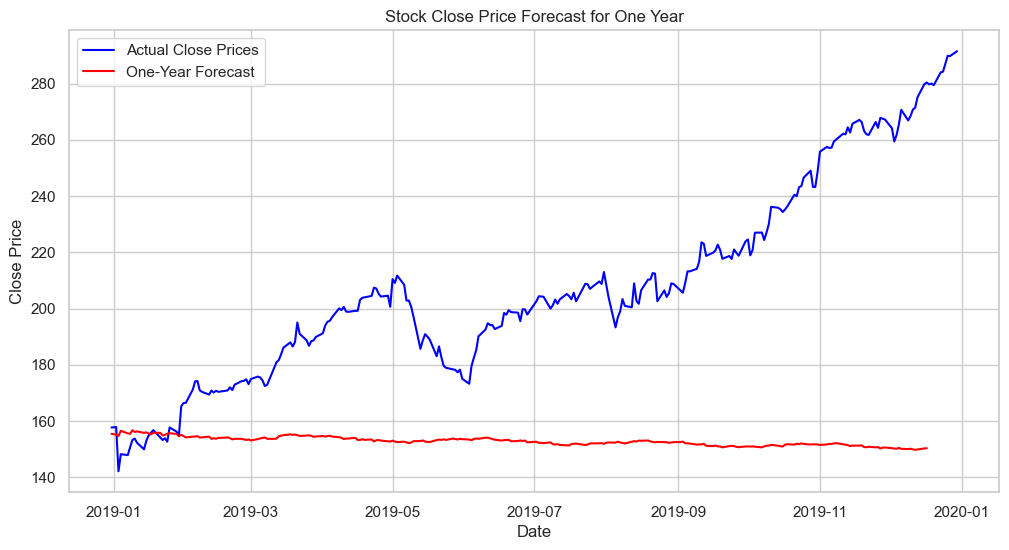

In [571]:
plt.figure(figsize=(12,6))
plt.plot(test['Close'],label='Actual Close Prices',color='blue')
plt.plot(forecast_index,forecast_org,label='One-Year Forecast',color='red')
plt.title('Stock Close Price Forecast for One Year')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

#### SARIMAX is also doing bad

## Exponential smoothing:
- Best For: Data with seasonality, trend, and irregular fluctuations.
- Why: Exponential smoothing methods like Holt-Winters use weighted averages to give recent data more importance. This can quickly adjust to changes and capture seasonality and trend without overfitting.
- Limitations: Exponential smoothing doesn’t work well for long-term forecasts with complex seasonality. It also assumes seasonal patterns are constant over time.

In [20]:
# data must be positive for ExSmoothing
train['diff_positive'] = train['diff'] + abs(train['diff'].min()) + 1

In [21]:
ets_model=ExponentialSmoothing(train['diff'],trend='add',seasonal='add',
                                seasonal_periods=30).fit()
ets_model.summary()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:                     diff   No. Observations:                 1758
Model:             ExponentialSmoothing   SSE                           6396.580
Optimized:                         True   AIC                           2338.609
Trend:                         Additive   BIC                           2524.655
Seasonal:                      Additive   AICC                          2340.157
Seasonal Periods:                    30   Date:                 Wed, 20 Nov 2024
Box-Cox:                          False   Time:                         13:04:54
Box-Cox Coeff.:                    None                                         
=================================================================================
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level              5.0004e-08                alpha                 True
smoothing_trend              1.0622e-12                 beta                 True
smoothing_seasonal           3.5105e-08                gamma                 True
initial_level                 0.0918471                  l.0                 True
initial_trend               -3.1304e-05                  b.0                 True
initial_seasons.0             0.1752894                  s.0                 True
initial_seasons.1            -0.1835160                  s.1                 True
initial_seasons.2             0.0950447                  s.2                 True
initial_seasons.3            -0.3421102                  s.3                 True
initial_seasons.4             0.1190723                  s.4                 True
initial_seasons.5            -0.0180704                  s.5                 True
initial_seasons.6            -0.1250732                  s.6                 True
initial_seasons.7             0.1806945                  s.7                 True
initial_seasons.8            -0.0241885                  s.8                 True
initial_seasons.9            -0.0630682                  s.9                 True
initial_seasons.10           -0.1272439                 s.10                 True
initial_seasons.11           -0.2695715                 s.11                 True
initial_seasons.12           -0.0253389                 s.12                 True
initial_seasons.13           -0.0292576                 s.13                 True
initial_seasons.14            0.3205459                 s.14                 True
initial_seasons.15            0.2520671                 s.15                 True
initial_seasons.16           -0.1000474                 s.16                 True
initial_seasons.17            0.4577593                 s.17                 True
initial_seasons.18           -0.2637776                 s.18                 True
initial_seasons.19           -0.2311678                 s.19                 True
initial_seasons.20           -0.1019247                 s.20                 True
initial_seasons.21           -0.3049983                 s.21                 True
initial_seasons.22           -0.1833021                 s.22                 True
initial_seasons.23           -0.0252539                 s.23                 True
initial_seasons.24            0.0795379                 s.24                 True
initial_seasons.25            0.3460027                 s.25                 True
initial_seasons.26            0.1306816                 s.26                 True
initial_seasons.27            0.1078750                 s.27                 True
initial_seasons.28           -0.0029805                 s.28                 True
initial_seasons.29           -0.1157987                 s.29                 True
--------------------------

In [22]:
forecast_steps=252
forecast=ets_model.forecast(steps=252)
forecast_org= forecast.cumsum() + df1['Close'].iloc[-252-1]
forecast_index= pd.date_range(start=train.index[-1],periods=forecast_steps+1,freq='B')[1:]

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [189]:
train_predictions=ets_model.predict(start=0, end=1757)
train_predictions_org=train_predictions.cumsum()+df1['Close'].iloc[0]

# RMSE
ets_train_rmse=root_mean_squared_error(train['Close'],train_predictions_org )
ets_test_rmse=root_mean_squared_error(forecast_org,test['Close'] )
print("RMSE for train of ets Model:",ets_train_rmse)
print("RMSE for test of ets Model:",ets_test_rmse)

RMSE for train of ets Model: 23.180178899643263
RMSE for test of ets Model: 65.33441278105134


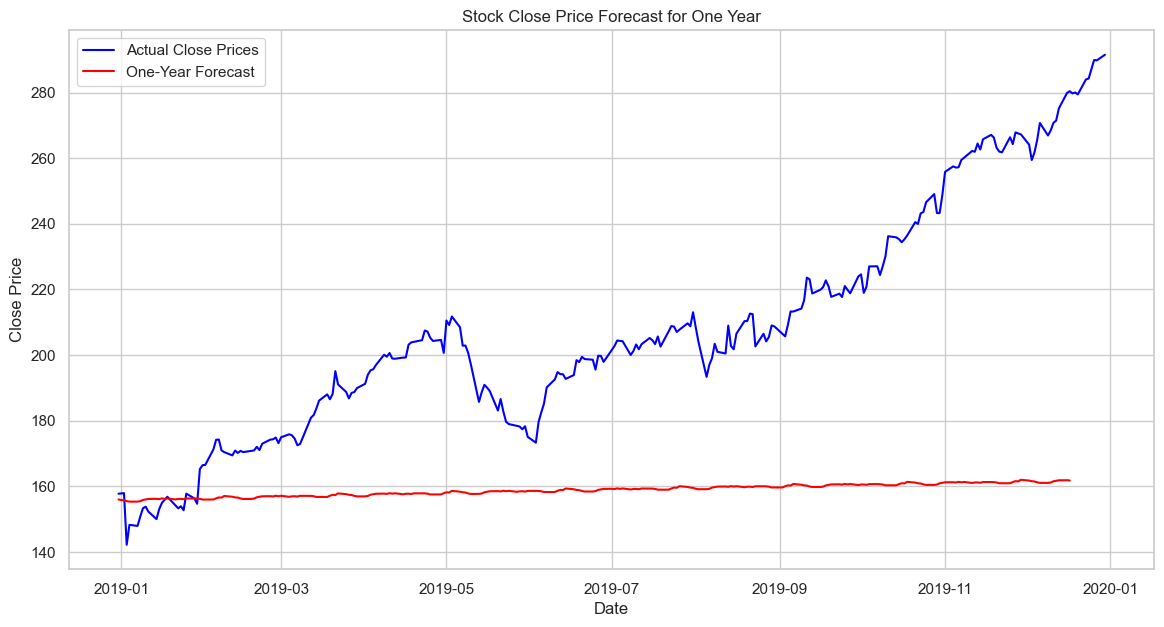

In [579]:
plt.figure(figsize=(14, 7))
plt.plot(test['Close'], label='Actual Close Prices', color='blue')
plt.plot(forecast_index, forecast_org, label='One-Year Forecast', color='red')
plt.title('Stock Close Price Forecast for One Year')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

#### Holt winter's Exponential smoothing is giving very bad results

## LSTM (Long Short-Term Memory) Networks
- Best For: Complex, non-linear data with long-range dependencies.
- Why: LSTMs are a type of recurrent neural network (RNN) that can capture long-term dependencies and complex patterns, making them highly effective for large, high-dimensional datasets or very volatile data (e.g., stock price data).
- Limitations: They are computationally intensive, require a large amount of data, and can be prone to overfitting if not regularized well.

In [127]:
# split the data into train and test
train=df1['Close'][:-252].values
# last one year exlcluding weekends considered as test
test=df1['Close'][-252:].values

In [128]:
train.shape, test.shape

((1758,), (252,))

- LSTMs require input data in sequential form, typically as a sliding window of past values to predict future values.
-  For example, to predict the next day’s price, create sequences with a defined window (e.g., 60 past time steps to predict the next value).
-  if we give past 60 value as sequential input then these will not be included in the output set
-  from 60th value of the training data to the end would be the output set
-  len(train)-window_size would be the size of the input set and output set

In [390]:
# Normalizing the data , before normalizing reshaping the data as the scaler needs 2D data
scaler=MinMaxScaler()
train_scaled=scaler.fit_transform(train.reshape(-1,1))
test_scaled=scaler.transform(test.reshape(-1,1))

In [391]:
# function to form an input (sequential form) and output set
def create_dataset(data, time_step=1):
    x, y = [], []
    for i in range(time_step, len(data)):
        x.append(data[i-time_step:i])   # past 60 steps
        y.append(data[i]) 
    return np.array(x), np.array(y)

In [392]:
# timestep or window size
time_step = 90

# calling the function and storing the x and y values
train_x, train_y = create_dataset(train_scaled, time_step)
test_x,test_y=create_dataset(test_scaled, time_step)

In [393]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((1668, 90, 1), (1668, 1), (162, 90, 1), (162, 1))

In [282]:
with open('test_x','wb') as file:
    pickle.dump(test_x,file)

### Hyperparameter tuning

In [394]:
#Define the model-building function
def build_model(hp):
    model = Sequential()
    # Input layer with first LSTM
    model.add(LSTM(50, return_sequences=True, input_shape=(60, 1),kernel_regularizer=regularizers.l2(0.01)))
    reg_strength = hp.Choice("reg", [0.01, 0.001, 0.02])
    # Additional LSTM layers with hyperparameters for units and dropout
    for i in range(hp.Int('num_layers', 1, 4)):  
        model.add(LSTM(units=hp.Choice('units', [30, 50, 100, 150]), return_sequences=True,kernel_regularizer=regularizers.l2(reg_strength) ))
        model.add(Dropout(hp.Float('drop', 0.1, 0.5, step=0.1))) 
    # Output layer
    model.add(Dense(1))
    
    learning_rate = hp.Choice('lr', [0.001, 0.01, 0.1])
    
    # Select optimizer based on string, then apply chosen learning rate
    optimizer_choice = hp.Choice('optimizer', ['adam', 'sgd', 'adadelta'])
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer_choice == 'adadelta':
        optimizer = Adadelta(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model


In [399]:

# Initialize the RandomSearch tuner
tuner=RandomSearch(build_model,objective='val_loss', max_trials=10, directory='my_dir',project_name='keras-tuner-train-data')

# hyperparameter search
tuner.search(train_x,train_y, validation_data=(test_x,test_y),epochs=20)

Trial 10 Complete [00h 02m 56s]
val_loss: 0.3147001564502716

Best val_loss So Far: 0.0444587767124176
Total elapsed time: 00h 38m 55s


In [401]:
tuner.get_best_hyperparameters()[0].values

{'reg': 0.001,
 'num_layers': 1,
 'units': 50,
 'drop': 0.30000000000000004,
 'lr': 0.01,
 'optimizer': 'adam'}

In [402]:
# final model build
best_model=Sequential()
best_model.add(LSTM(50, return_sequences=True, input_shape=(90, 1),kernel_regularizer=regularizers.l2(0.01)))
best_model.add(Dropout(0.3))
best_model.add(LSTM(50, return_sequences=False, kernel_regularizer=regularizers.l2(0.001)))
best_model.add(Dropout(0.3))

best_model.add(Dense(1))

optimizer = Adam(learning_rate=0.01)
best_model.compile(optimizer=optimizer, loss='mean_squared_error')


#lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
best_model.fit(train_x, train_y, validation_data=(test_x, test_y), 
                epochs=50, callbacks=[early_stopping])


Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step - loss: 0.0649 - val_loss: 0.0108
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0104 - val_loss: 0.0073
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0063 - val_loss: 0.0110
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0046 - val_loss: 0.0114
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0051 - val_loss: 0.0560
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - loss: 0.0105 - val_loss: 0.0136
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0048 - val_loss: 0.0064
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.0037 - val_loss: 0.0045
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0044 - val_loss: 0.0094
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0037 - val_loss: 0.0102
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0039 - val_loss: 0.0053
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0

In [403]:
# predictions 
train_pred=best_model.predict(train_x)
test_pred=best_model.predict(test_x)
train_pred

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


array([[0.12041157],
       [0.11889029],
       [0.1172168 ],
       ...,
       [0.64640176],
       [0.63857293],
       [0.62971056]], dtype=float32)

In [363]:
train_y

array([[0.13589579],
       [0.13180328],
       [0.12605756],
       ...,
       [0.57510775],
       [0.56932147],
       [0.56977531]])

In [405]:
# reverse scaling the prediction values
train_pred_org=scaler.inverse_transform(train_pred)
test_pred_org=scaler.inverse_transform(test_pred)

In [406]:
# prediction in original form
train_pred_org

array([[ 77.01615 ],
       [ 76.747986],
       [ 76.45298 ],
       ...,
       [169.7377  ],
       [168.35764 ],
       [166.79538 ]], dtype=float32)

In [407]:
# original values
train[90:].reshape(-1,1)

array([[ 79.745712],
       [ 79.024284],
       [ 78.011429],
       ...,
       [157.169998],
       [156.149994],
       [156.229996]])

In [408]:
lstm_train_rmse=root_mean_squared_error(train[90:], train_pred_org)
lstm_test_rmse=root_mean_squared_error(test[90:], test_pred_org)
print("Train RMSE:",lstm_train_rmse)
print("Test RMSE:",lstm_test_rmse)

Train RMSE: 6.499350805355338
Test RMSE: 10.075298177539848


In [409]:
# from 2D to 1D
train_pred_org.ravel().shape

(1668,)

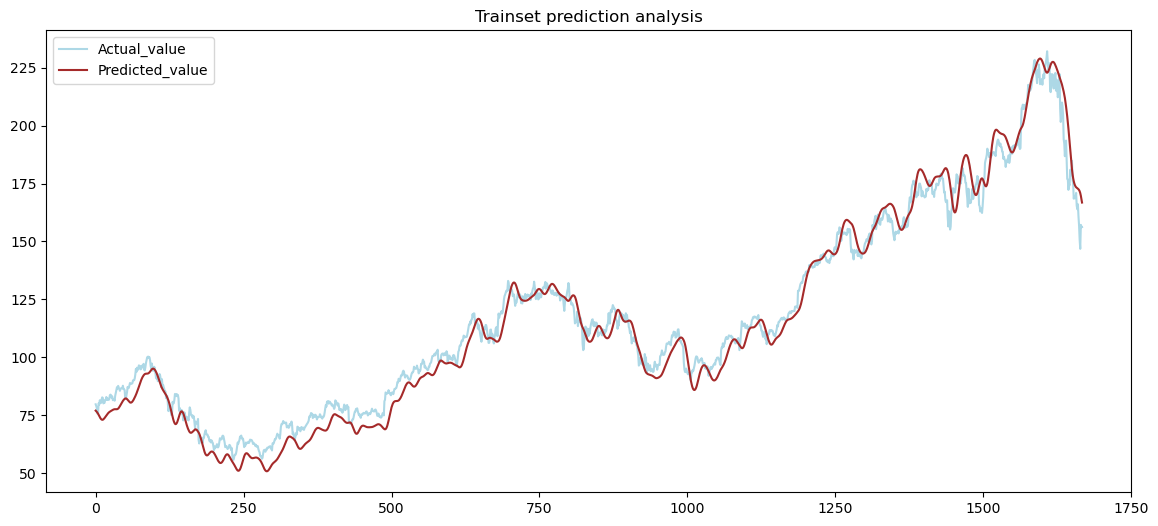

In [410]:
plt.figure(figsize=(14,6))
sns.lineplot(y=train[90:],x=range(len(train[90:])), label='Actual_value', color='lightblue')
sns.lineplot(y=train_pred_org.ravel(),x=range(len(train_pred_org)), label='Predicted_value', color='brown')
plt.title('Trainset prediction analysis')
plt.legend()
plt.show()

In [412]:
test[90:].shape,test_pred_org.shape

((162,), (162, 1))

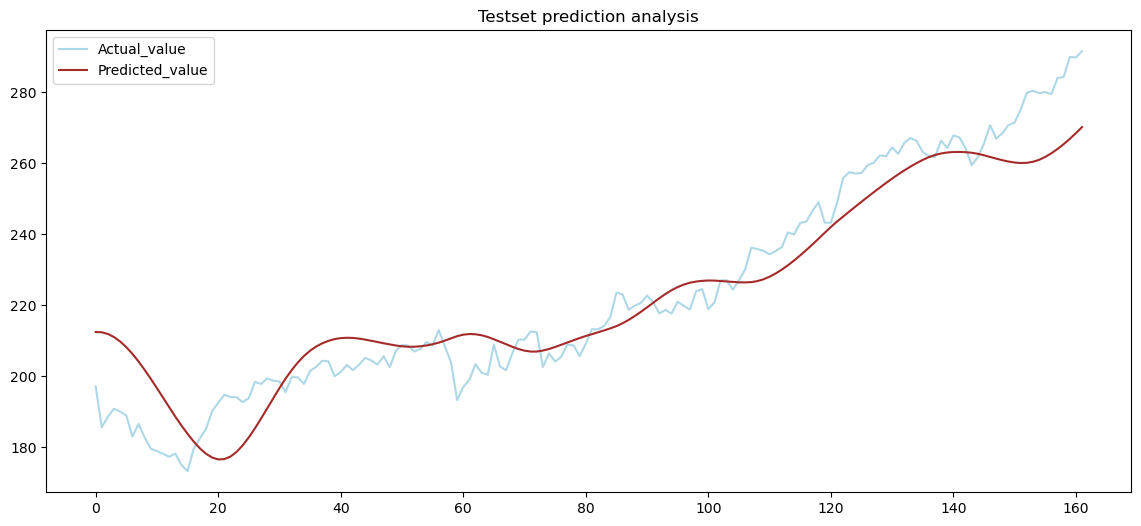

In [411]:
plt.figure(figsize=(14,6))
sns.lineplot(y=test[90:],x=range(len(test[90:])), label='Actual_value', color='lightblue')
sns.lineplot(y=test_pred_org.ravel(),x=range(len(test_pred_org)), label='Predicted_value', color='brown')
plt.title('Testset prediction analysis')
plt.legend()
plt.show()

In [256]:
# Analysis of RMSE values of different models
models=['Arima','Sarima','ExponentialS','LSTM']
trainRmse=[arima_train_rmse, sarima_train_rmse,ets_train_rmse, lstm_train_rmse]
testRmse=[arima_test_rmse,sarima_test_rmse,ets_test_rmse, lstm_test_rmse]
Models_rmse=pd.DataFrame({'TrainRMSE':trainRmse, 'TestRMSE':testRmse}, index=models)
Models_rmse

TrainRMSE   TestRMSE
Arima         19.468333  52.522263
Sarima        79.596092  65.334413
ExponentialS  23.180179  65.334413
LSTM          11.646511  11.434510

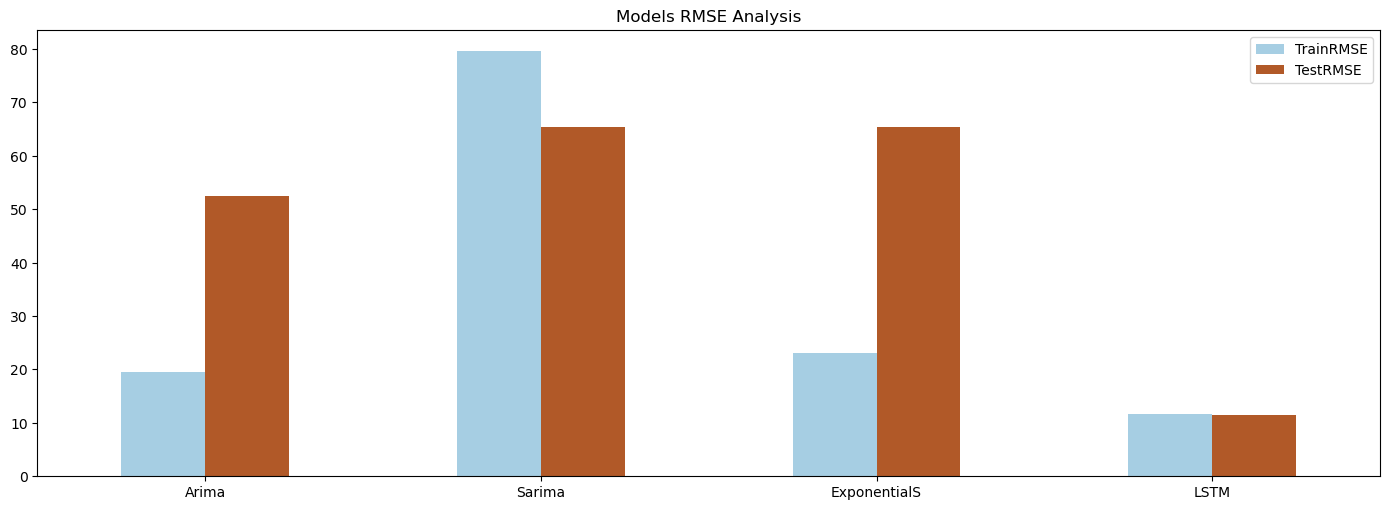

In [316]:
Models_rmse.plot(kind='bar',figsize=(14,5),colormap='Paired')
plt.xticks(rotation=360)
plt.tight_layout()
plt.title('Models RMSE Analysis')
plt.show()

In [167]:
df1['Close']

Date
2012-01-04     59.062859
2012-01-05     59.718571
2012-01-06     60.342857
2012-01-09     60.247143
2012-01-10     60.462856
                 ...    
2019-12-23    284.000000
2019-12-24    284.269989
2019-12-26    289.910004
2019-12-27    289.799988
2019-12-30    291.519989
Name: Close, Length: 2010, dtype: float64

# Final stacked LSTM model on complete data 

In [4]:
# function to form an input (sequential form) and output set
def create_dataset(data, time_step=1):
    x, y = [], []
    for i in range(time_step, len(data)):
        x.append(data[i-time_step:i])   # past 60 steps
        y.append(data[i]) 
    return np.array(x), np.array(y)

In [5]:
# transforming the original data
time_step=365
data_x, data_y = create_dataset(df1['log_close'], time_step)
scaler_x=MinMaxScaler()
scaler_y=MinMaxScaler()
X=scaler_x.fit_transform(data_x)
Y=scaler_y.fit_transform(data_y.reshape(-1,1))

X_scaled= X.reshape(X.shape[0], X.shape[1], 1)
X_scaled.shape, Y.shape

((1646, 365, 1), (1646, 1))

In [173]:
X_scaled

array([[[0.03623281],
        [0.03999288],
        [0.04773836],
        ...,
        [0.22165772],
        [0.27060723],
        [0.26831492]],

       [[0.03999288],
        [0.04773836],
        [0.05503401],
        ...,
        [0.27387215],
        [0.26831492],
        [0.26360363]],

       [[0.04773836],
        [0.05503401],
        [0.05392037],
        ...,
        [0.27155219],
        [0.26360363],
        [0.24415522]],

       ...,

       [[0.91538057],
        [0.92718331],
        [0.94076708],
        ...,
        [0.98947581],
        [0.98750206],
        [0.98807865]],

       [[0.92718331],
        [0.94076708],
        [0.94070128],
        ...,
        [0.99941645],
        [0.98807865],
        [1.        ]],

       [[0.94076708],
        [0.94070128],
        [0.94368844],
        ...,
        [1.        ],
        [1.        ],
        [0.99976968]]])

### Hyperparameter tuning for best values:

In [345]:
# Initialize the RandomSearch tuner
tuner=RandomSearch(build_model,objective='val_loss', max_trials=10, directory='my_dir',project_name='keras-tuner-complete-data')

# hyperparameter search
tuner.search(X_scaled,Y, validation_split=0.3,epochs=30)

Reloading Tuner from my_dir\keras-tuner-complete-data\tuner0.json


In [ ]:
tuner.results_summary()

In [347]:
# best hyperparameters
tuner.get_best_hyperparameters()[0].values

{'reg': 0.001,
 'num_layers': 4,
 'units': 150,
 'drop': 0.5,
 'lr': 0.001,
 'optimizer': 'adam'}

### Although the hyperparameter tuning yielded good scores, the model struggled to generalize the patterns, learning the noise and minor fluctuations, leading to overfitting. Instead, we manually tested different hyperparameters with a higher number of epochs to improve the model’s ability to generalize.

In [201]:
# final model build
final_model=Sequential()
final_model.add(LSTM(30, return_sequences=True, input_shape=(365, 1),kernel_regularizer=regularizers.l2(0.1)))
final_model.add(Dropout(0.5))
final_model.add(LSTM(30, return_sequences=False, kernel_regularizer=regularizers.l2(0.1)))
final_model.add(Dropout(0.5))

final_model.add(Dense(1))

optimizer = Adam(learning_rate=0.00001)
final_model.compile(optimizer=optimizer, loss='mean_squared_error')


#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) callbacks=[early_stopping]
final_model.fit(X_scaled, Y, validation_split=0.3, shuffle=False,
                epochs=500 )

Epoch 1/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 32s 636ms/step - loss: 5.0610 - val_loss: 5.4982
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 39s 583ms/step - loss: 5.0295 - val_loss: 5.4503
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 577ms/step - loss: 4.9968 - val_loss: 5.4042
Epoch 4/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 44s 653ms/step - loss: 4.9708 - val_loss: 5.3590
Epoch 5/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 39s 600ms/step - loss: 4.9413 - val_loss: 5.3146
Epoch 6/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 594ms/step - loss: 4.9127 - val_loss: 5.2708
Epoch 7/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 37s 479ms/step - loss: 4.8813 - val_loss: 5.2273
Epoch 8/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 562ms/step - loss: 4.8531 - val_loss: 5.1845
Epoch 9/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 556ms/step - loss: 4.8257 - val_loss: 5.1423
Epoch 10/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 516ms/step - loss: 4.7961 - val_loss: 5.1003
Epoch 11/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 563ms/step - loss: 4.7706 - val_loss: 5.0586
Epoch 12/500
36/36 ━━━━━━━━━━━

In [10]:
predictions=final_model.predict(X_scaled)

predictions_unscaled=scaler_y.inverse_transform(predictions)
predictions_unscaled=np.exp(predictions_unscaled)

print("RMSE:",root_mean_squared_error(predictions_unscaled,df1['Close'][365:]))
print("MSE:",mean_squared_error(predictions_unscaled,df1['Close'][365:]))
print("R-squared value:",r2_score(predictions_unscaled,df1['Close'][365:]))

52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 229ms/step
RMSE: 16.16275978559478
MSE: 261.23480388683976
R-squared value: 0.9125933793396821


In [315]:
#original values
pd.DataFrame({"Actual":df1['Close'][-30:].values,"Predictions":predictions_unscaled.ravel()[-30:]})

Actual  Predictions
0   265.760010   260.083008
1   267.100006   261.211395
2   266.290009   262.361725
3   263.190002   263.532043
4   262.010010   264.714996
5   261.779999   265.908875
6   266.369995   267.112122
7   264.290009   268.323303
8   267.839996   269.537842
9   267.250000   270.758118
10  264.160004   271.986115
11  259.450012   273.216339
12  261.739990   274.439392
13  265.579987   275.655548
14  270.709991   276.866821
15  266.920013   278.078369
16  268.480011   279.285919
17  270.769989   280.488647
18  271.459991   281.691223
19  275.149994   282.894867
20  279.859985   284.101532
21  280.410004   285.315063
22  279.739990   286.538574
23  280.019989   287.770355
24  279.440002   289.014465
25  284.000000   290.268402
26  284.269989   291.531616
27  289.910004   292.801086
28  289.799988   294.086121
29  291.519989   295.390228

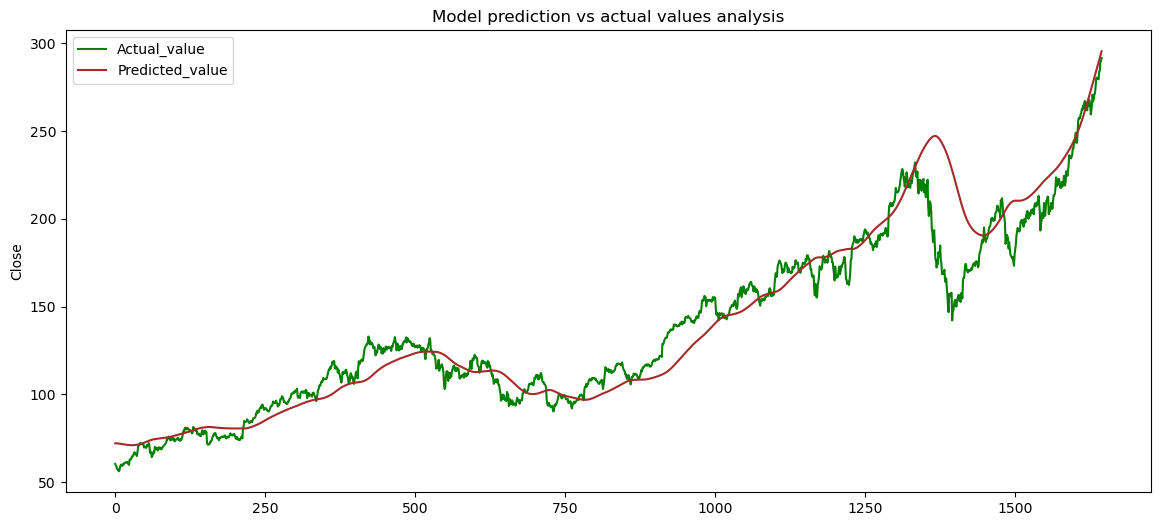

In [316]:
plt.figure(figsize=(14,6))
sns.lineplot(y=df1['Close'][365:],x=range(len(df1['Close'][365:])), label='Actual_value', color='green')
sns.lineplot(y=predictions_unscaled.ravel(),x=range(len(predictions_unscaled)), label='Predicted_value', color='brown')
plt.title('Model prediction vs actual values analysis')
plt.legend()
plt.show()

# Forecasting for next 30 days

In [14]:
last_sequence=X_scaled[-1].reshape(1,-1)

last_sequence=np.expand_dims(last_sequence, -1)
steps=30
forecasts=[]
for _ in range(steps):
    next_pred=final_model.predict(last_sequence)[0][0]
    forecasts.append(next_pred)
    next_input = np.array(next_pred).reshape(1, 1, 1)
    last_sequence=np.append(last_sequence[:,1:,:],next_input,axis=1)

# Reverse the transformations
forecasts_unscaled=scaler_y.inverse_transform(np.array(forecasts).reshape(-1, 1))
forecasts_unscaled=np.exp(forecasts_unscaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11

In [15]:
forecasts_unscaled

array([[297.05005],
       [297.48788],
       [297.92755],
       [298.36996],
       [298.81635],
       [299.26694],
       [299.72235],
       [300.18292],
       [300.64877],
       [301.11978],
       [301.59598],
       [302.07727],
       [302.5637 ],
       [303.05518],
       [303.5515 ],
       [304.05292],
       [304.55902],
       [305.06992],
       [305.58502],
       [306.1051 ],
       [306.62924],
       [307.15768],
       [307.69052],
       [308.2274 ],
       [308.7686 ],
       [309.31354],
       [309.8624 ],
       [310.41534],
       [310.97226],
       [311.5325 ]], dtype=float32)

In [7]:
import pickle
with open(r"C:\Users\sahub\Desktop\P461_stock_analysis\lstm_model.pkl", "rb") as file:
    final_model=pickle.load(file)

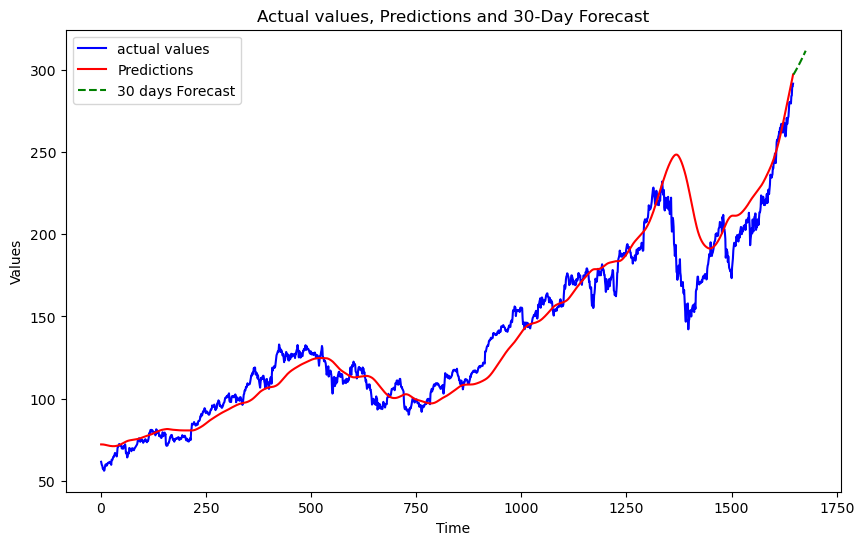

In [16]:

original_index = np.arange(1, len(df1['Close'][365:].ravel()) + 1)

forecast_index = np.arange(len(predictions_unscaled.ravel()) + 1, 
                            len(predictions_unscaled.ravel()) + len(forecasts_unscaled) + 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(original_index, df1['Close'][365:].ravel(), label='actual values', color='blue')

plt.plot(original_index, predictions_unscaled, label='Predictions', color='red')

plt.plot(forecast_index,forecasts_unscaled, label=f'{steps} days Forecast', color='green', linestyle='--')

# Adding details
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Actual values, Predictions and 30-Day Forecast')
plt.legend()
plt.show()


In [320]:
import pickle
with open("lstm_model.pkl", 'wb') as file:
    pickle.dump(final_model,file)

with open("scaler", 'wb') as file:
    pickle.dump(scaler_y, file)

with open ("X_scaled", 'wb') as file:
    pickle.dump(X_scaled, file)